In [1]:
import sys
sys.path.append("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import matplotlib.animation as animation
import scipy as sc
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import networkx as nx

## Fonctions utiles

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")
n_runs = len(meta)
n_wins = 464
dfc_train_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_test_propofol = dfc[(meta["monkey"] == "jade") & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))
dfc_train_background = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])].reshape((-1, n_wins, 82, 82))
dfc_test_background = dfc[(meta["monkey"] == "jade")].reshape((-1, n_wins, 82, 82))
conditions_train = meta["condition"][meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
conditions_test = meta["condition"][meta["monkey"].isin(['jade']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
dict_conditions = {"light-propofol":0, "deep-propofol":1}
labels_train = [dict_conditions[elem] for elem in conditions_train]
labels_test = [dict_conditions[elem] for elem in conditions_test]

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/dfc.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/meta.csv")
iu = np.triu_indices(82,k=1)
dfc_flat = dfc[:,:,iu[0],iu[1]]

id_sessions_awake = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake"]
id_sessions_light_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol"]
id_sessions_deep_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol"]
id_sessions_light_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2"]
id_sessions_deep_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4"]

In [4]:
id_sessions_almira = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "almira" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_jade = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "jade" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_khali = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "khali" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_kimiko = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "kimiko" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_rana = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "rana" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]

## PCA on awake-sevoflurane dataset

In [40]:
id_sessions_sevoflurane = np.concatenate([id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane]).astype(int)
id_sessions_awake_anesthesia = np.concatenate([id_sessions_awake,id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane]).astype(int)
id_sessions_awake_propofol = np.concatenate([id_sessions_awake,id_sessions_light_propofol,id_sessions_deep_propofol]).astype(int)
X = dfc_flat[id_sessions_awake_anesthesia,:,:].reshape(-1,3321)
y = np.array([0]*461* len(id_sessions_awake) + [1]*461*len(id_sessions_light_sevoflurane) + [2]*461*len(id_sessions_deep_sevoflurane))
X_propofol = dfc_flat[id_sessions_awake_propofol,:,:].reshape(-1,3321)
#X_sevoflurane = dfc_flat[id_sessions_awake_sevoflurane,:,:].reshape(-1,3321)
X_almira = dfc_flat[id_sessions_almira,:,:].reshape(-1,3321)
X_jade = dfc_flat[id_sessions_jade,:,:].reshape(-1,3321)
X_khali = dfc_flat[id_sessions_khali,:,:].reshape(-1,3321)
X_kimiko = dfc_flat[id_sessions_kimiko,:,:].reshape(-1,3321)
X_rana = dfc_flat[id_sessions_rana,:,:].reshape(-1,3321)

In [56]:
pca = PCA(n_components=3321)
X_reduced = pca.fit_transform(X)
v = pca.components_.T
clf = SVC(gamma="auto",kernel="linear")
clf.fit(X_reduced,y)

In [49]:
60*(60-1)//2

1770

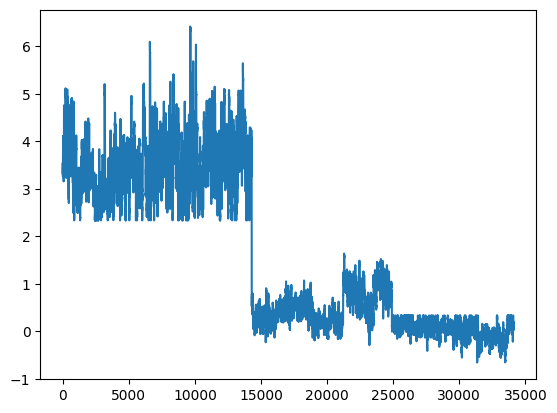

In [51]:
u = clf.coef_.T
X_pred = X.dot(v).dot(u)
X_almira_reduced = X_almira.dot(v).dot(u)
X_jade_reduced = X_jade.dot(v).dot(u)
X_khali_reduced = X_khali.dot(v).dot(u)
X_kimiko_reduced = X_kimiko.dot(v).dot(u)
X_rana_reduced = X_rana.dot(v).dot(u)
plt.plot(X_pred[:,1])

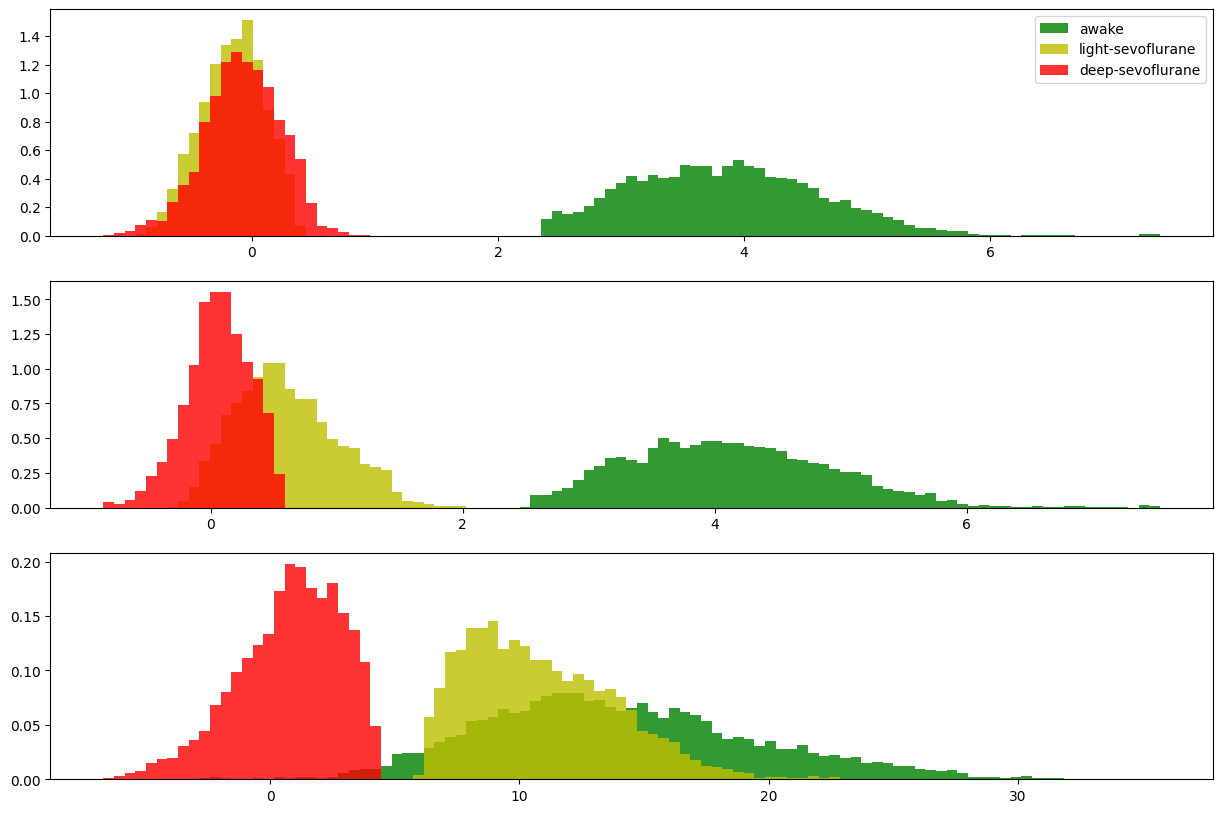

In [44]:
a = len(id_sessions_awake)
b = len(id_sessions_light_sevoflurane)
c = len(id_sessions_deep_sevoflurane)

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

for i in range(3):
    fig.add_subplot(3,1, i+1)

    v_min = np.min(X_pred[:,i])
    v_max = np.max(X_pred[:,i])
    bins = np.linspace(v_min,v_max,100)

    counts_awake,_ = np.histogram(X_pred[:a*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_awake,density = True,label="awake",color="g",alpha=0.8)

    counts_light_sevoflurane,_ = np.histogram(X_pred[a*461:(a+b)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_sevoflurane,density = True,label="light-sevoflurane",color="y",alpha=0.8)

    counts_deep_sevoflurane,_ = np.histogram(X_pred[(a+b)*461:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_sevoflurane,density = True,label="deep-sevoflurane",color="r",alpha=0.8)
    
    if i == 0:
        plt.legend()
    compteur += 1 
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

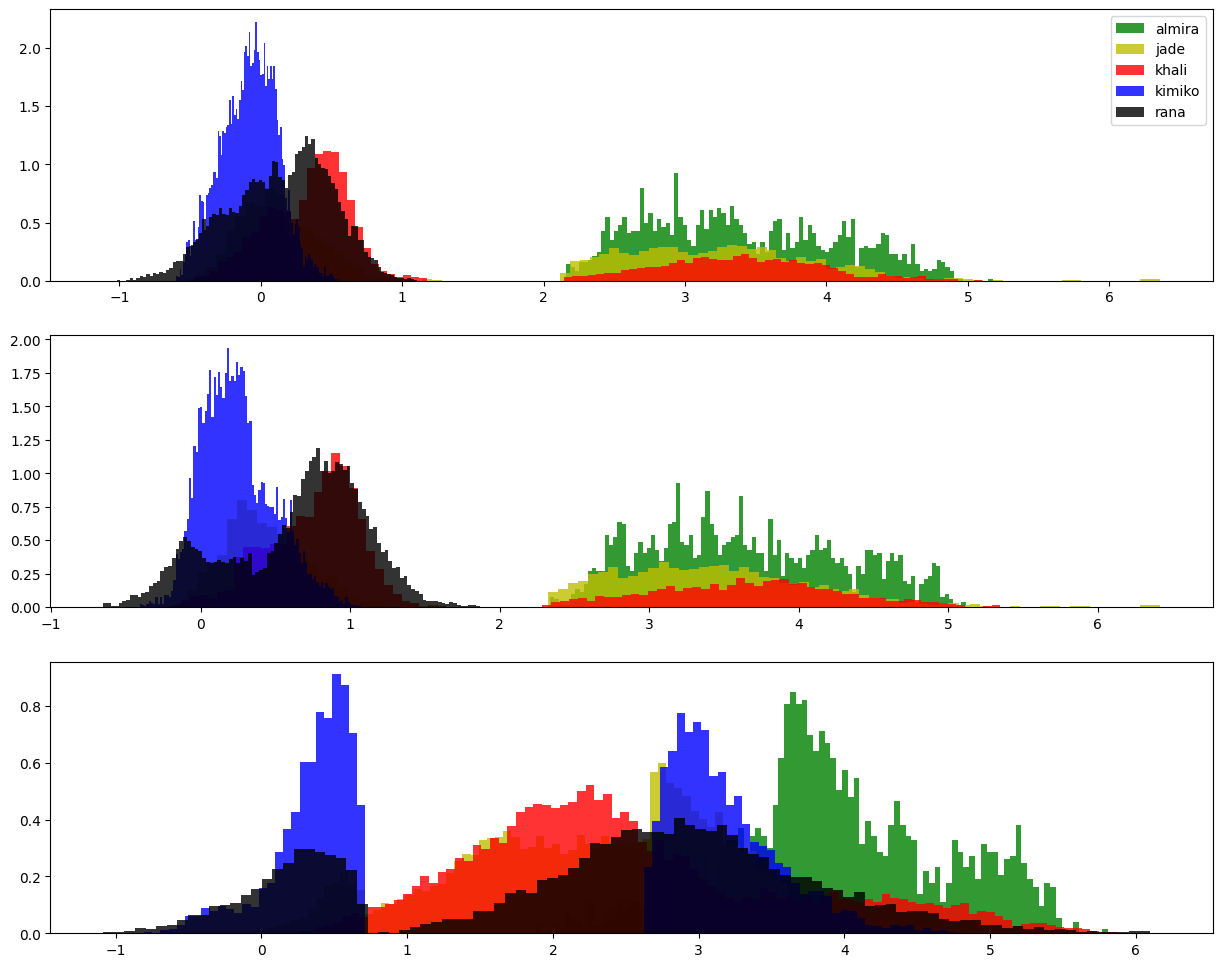

In [52]:
a = len(id_sessions_awake)
b = len(id_sessions_light_sevoflurane)
c = len(id_sessions_light_propofol)
d = len(id_sessions_deep_sevoflurane)
e = len(id_sessions_deep_propofol)

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,12))

for i in range(3):
    fig.add_subplot(3,1, i+1)

    v_min = np.min(X_almira_reduced[:,i])
    v_max = np.max(X_almira_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_almira,_ = np.histogram(X_almira_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_almira,density = True,label="almira",color="g",alpha=0.8)

    v_min = np.min(X_jade_reduced[:,i])
    v_max = np.max(X_jade_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_jade,_ = np.histogram(X_jade_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_jade,density = True,label="jade",color="y",alpha=0.8)

    v_min = np.min(X_khali_reduced[:,i])
    v_max = np.max(X_khali_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_khali,_ = np.histogram(X_khali_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_khali,density = True,label="khali",color="r",alpha=0.8)

    v_min = np.min(X_kimiko_reduced[:,i])
    v_max = np.max(X_kimiko_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_kimiko,_ = np.histogram(X_kimiko_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_kimiko,density = True,label="kimiko",color="b",alpha=0.8)

    v_min = np.min(X_rana_reduced[:,i])
    v_max = np.max(X_rana_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_rana,_ = np.histogram(X_rana_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_rana,density = True,label="rana",color="k",alpha=0.8)
    if i == 0:
        plt.legend()
    compteur += 1 
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

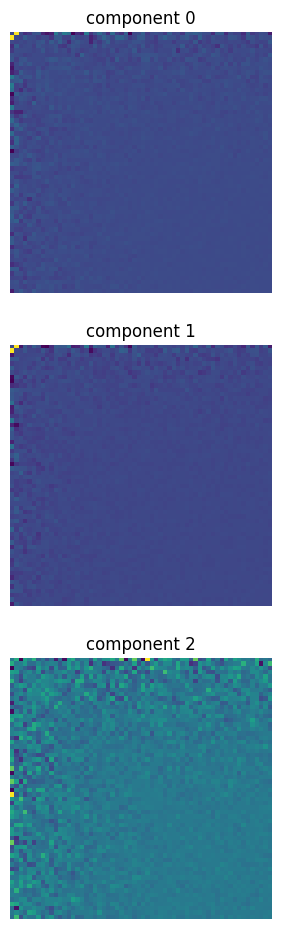

In [55]:
fig = plt.figure(figsize=(40,40))
n = 60
for i in range(3):
    im = np.zeros((n,n))
    iu = np.triu_indices(n,k=1)
    il = np.tril_indices(n,k=-1)
    im[iu[0],iu[1]] = u[:,i]
    im = np.transpose(im)
    im[iu[0],iu[1]] = u[:,i]
    fig.add_subplot(10,1,i+1)
    plt.imshow(im)
    plt.axis("off")
    plt.title(label="component {}".format(i))
plt.show()

## Essai avec un train/test split

In [79]:
meta[(meta["monkey"] == "kimiko") & (meta["condition"].isin(["sevoflurane2","sevoflurane4"]))]

,Unnamed: 0,monkey,ses,run,condition
116,116,kimiko,20150710,5,sevoflurane2
117,117,kimiko,20150710,6,sevoflurane2
118,118,kimiko,20150710,7,sevoflurane2
119,119,kimiko,20150710,8,sevoflurane2
120,120,kimiko,20150710,9,sevoflurane2
121,121,kimiko,20150724,10,sevoflurane2
122,122,kimiko,20150724,11,sevoflurane2
123,123,kimiko,20150724,12,sevoflurane2
124,124,kimiko,20150724,8,sevoflurane2
125,125,kimiko,20150724,9,sevoflurane2


In [21]:
id_sessions_awake_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana"]]
id_sessions_light_propofol_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","jade"]]
id_sessions_deep_propofol_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","jade"]]
id_sessions_light_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ["jade","rana"]]
id_sessions_deep_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ["jade","rana"]]

id_sessions_awake_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ["jade"]]
id_sessions_light_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ["kimiko"]]
id_sessions_deep_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ["kimiko"]]
id_sessions_light_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ["kimiko"]]
id_sessions_deep_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ["kimiko"]]

In [38]:
id_sessions_anesthesia_train = np.concatenate([id_sessions_light_sevoflurane_train,id_sessions_deep_sevoflurane_train]).astype(int)
id_sessions_awake_anesthesia_train = np.concatenate([id_sessions_awake_train,id_sessions_light_sevoflurane_train,id_sessions_deep_sevoflurane_train]).astype(int)
id_sessions_anesthesia_test = np.concatenate([id_sessions_light_sevoflurane_test,id_sessions_deep_sevoflurane_test]).astype(int)
id_sessions_awake_anesthesia_test = np.concatenate([id_sessions_awake_test,id_sessions_light_sevoflurane_test,id_sessions_deep_sevoflurane_test]).astype(int)
X_train = dfc_flat[id_sessions_anesthesia_train,:,:].reshape(-1,3321)
X_train_awake = dfc_flat[id_sessions_awake_anesthesia_train,:,:].reshape(-1,3321)
X_test = dfc_flat[id_sessions_anesthesia_test,:,:].reshape(-1,3321)
X_test_awake = dfc_flat[id_sessions_awake_anesthesia_test,:,:].reshape(-1,3321)
y_train = np.array([0]*461*len(id_sessions_light_sevoflurane_train) + [1]*461*len(id_sessions_deep_sevoflurane_train))
y_test = np.array([0]*461*len(id_sessions_light_sevoflurane_test) + [1]*461*len(id_sessions_deep_sevoflurane_test))
y_train_name = np.array(["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane_train) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane_train))
y_test_name = np.array(["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane_test) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane_test))
y_train_awake_name = np.array(["awake"]*461*len(id_sessions_awake_train) + ["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane_train) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane_train))
y_train_awake = np.array([0]*461*len(id_sessions_awake_train) + [1]*461*len(id_sessions_light_sevoflurane_train) + [2]*461*len(id_sessions_deep_sevoflurane_train))
y_test_awake_name = np.array(["awake"]*461*len(id_sessions_awake_test) + ["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane_test) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane_test))
y_test_awake = np.array([0]*461*len(id_sessions_awake_test) + [1]*461*len(id_sessions_light_sevoflurane_test) + [2]*461*len(id_sessions_deep_sevoflurane_test))
#X_sevoflurane = dfc_flat[id_sessions_awake_sevoflurane,:,:].reshape(-1,3321)
X_almira = dfc_flat[id_sessions_almira,:,:].reshape(-1,3321)
X_jade = dfc_flat[id_sessions_jade,:,:].reshape(-1,3321)
X_khali = dfc_flat[id_sessions_khali,:,:].reshape(-1,3321)
X_kimiko = dfc_flat[id_sessions_kimiko,:,:].reshape(-1,3321)
X_rana = dfc_flat[id_sessions_rana,:,:].reshape(-1,3321)

In [7]:
id_sessions_awake = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake"]
id_sessions_light_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2"]
id_sessions_deep_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4"]
id_sessions_awake_sevoflurane = np.concatenate([id_sessions_awake,id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane])
X_train = dfc_flat[id_sessions_awake_sevoflurane,:,:].reshape(-1,3321)
y_train_name = np.array(["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane))
y_train = np.array([0]*461*len(id_sessions_light_sevoflurane) + [1]*461*len(id_sessions_deep_sevoflurane))

In [32]:
clf = make_pipeline(StandardScaler(),LinearSVC(dual="auto",multi_class="crammer_singer"))
clf.fit(X_train_awake,y_train_awake)
u = clf[1].coef_.T
X_train_pred = clf[0].transform(X_train).dot(u)
X_train_awake_pred = clf[0].transform(X_train_awake).dot(u)
X_test_pred = clf[0].transform(X_test).dot(u)
X_test_awake_pred = clf[0].transform(X_test_awake).dot(u)
X_almira_reduced = clf[0].transform(X_almira).dot(u)
X_jade_reduced = clf[0].transform(X_jade).dot(u)
X_khali_reduced = clf[0].transform(X_khali).dot(u)
X_kimiko_reduced = clf[0].transform(X_kimiko).dot(u)
X_rana_reduced = clf[0].transform(X_rana).dot(u)

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1500x1000 with 0 Axes>

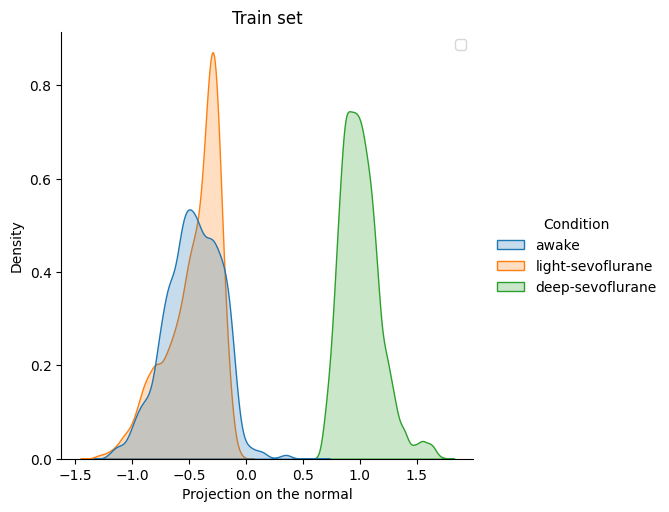

In [36]:
df_val = pd.DataFrame.from_dict({"val" : X_train_awake_pred[:,2].flatten()})
df_cond = pd.DataFrame.from_dict({"condition" : y_train_awake_name})

db_train = pd.concat([df_val,df_cond],axis = 1)
db_train.columns = ["Projection on the normal","Condition"]

fig = plt.figure(figsize=(15,10))

sns.displot(data = db_train, x = "Projection on the normal", hue = "Condition", kind="kde",  fill=True, color="g")

plt.title("Train set")
plt.legend()
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1500x1000 with 0 Axes>

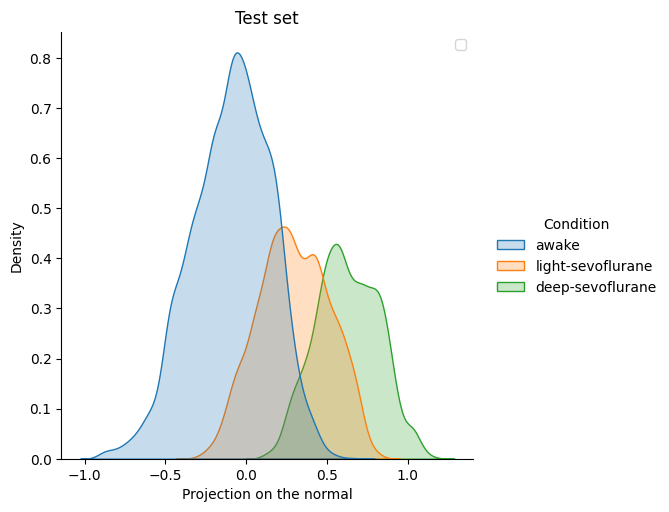

In [39]:
df_val = pd.DataFrame.from_dict({"val" : X_test_awake_pred[:,2].flatten()})
df_cond = pd.DataFrame.from_dict({"condition" : y_test_awake_name})

db_test = pd.concat([df_val,df_cond],axis = 1)
db_test.columns = ["Projection on the normal","Condition"]

fig = plt.figure(figsize=(15,10))

sns.displot(data = db_test, x = "Projection on the normal", hue = "Condition", kind="kde",  fill=True, color="g")

plt.title("Test set")
plt.legend()
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()


/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

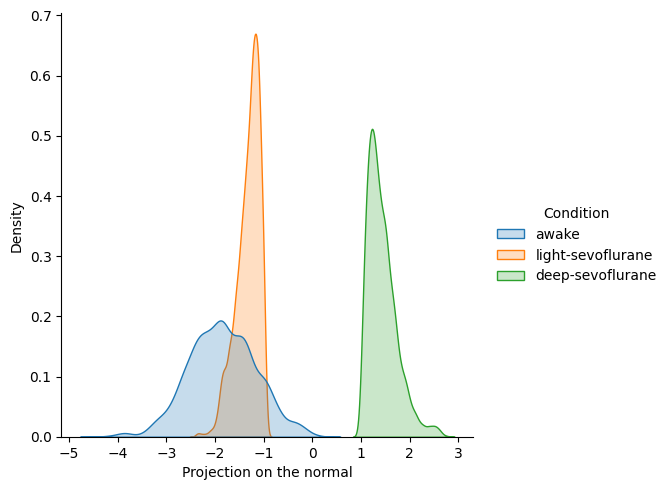

In [17]:
df_val = pd.DataFrame.from_dict({"val" : X_train_awake_pred[:,0].flatten()})
df_cond = pd.DataFrame.from_dict({"condition" : y_train_awake_name})

db_train = pd.concat([df_val,df_cond],axis = 1)
db_train.columns = ["Projection on the normal","Condition"]

fig = plt.figure(figsize=(15,10))

sns.displot(data = db_train, x = "Projection on the normal", hue = "Condition", kind="kde",  fill=True, color="g")

#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

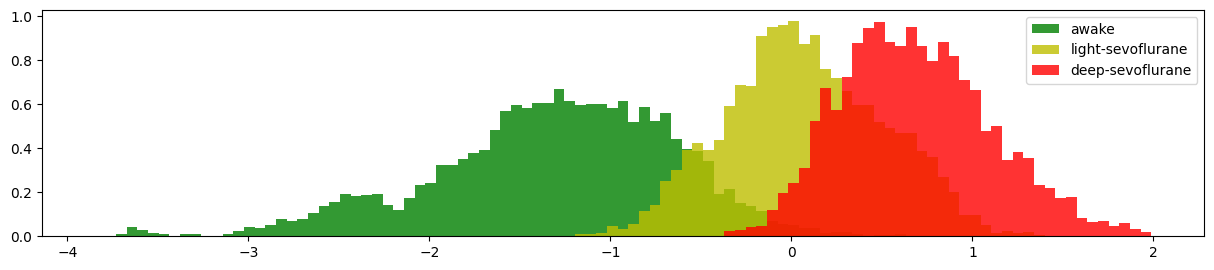

In [12]:
a = len(id_sessions_awake_test)
b = len(id_sessions_light_sevoflurane_test)
c = len(id_sessions_deep_sevoflurane_test)

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

for i in range(1):
    fig.add_subplot(3,1, i+1)

    v_min = np.min(X_test_awake_pred[:,i])
    v_max = np.max(X_test_awake_pred[:,i])
    bins = np.linspace(v_min,v_max,100)

    counts_awake,_ = np.histogram(X_test_awake_pred[:a*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_awake,density = True,label="awake",color="g",alpha=0.8)

    counts_light_sevoflurane,_ = np.histogram(X_test_awake_pred[a*461:(a+b)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_sevoflurane,density = True,label="light-sevoflurane",color="y",alpha=0.8)

    counts_deep_sevoflurane,_ = np.histogram(X_test_awake_pred[(a+b)*461:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_sevoflurane,density = True,label="deep-sevoflurane",color="r",alpha=0.8)
    
    if i == 0:
        plt.legend()
    compteur += 1 
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [30]:
y_train_num = np.array([0]*461*len(id_sessions_light_sevoflurane_train) + [1]*461*len(id_sessions_deep_sevoflurane_train))
val = np.linspace(np.min(X_test_pred),np.max(X_test_pred),300)
length = len(y_test)
fact0 = np.sum(y_test == 0)
fact1 = np.sum(y_test == 1)
accu = np.zeros((len(val)))
accu2 = X_test_pred[:,0].flatten()
for k in range(len(val)):
    pred = (accu2 > val[k]).astype(int)
    accu[k] = np.sum((y_test == 0) * (pred == 0)) / (2*fact0) + np.sum((y_test == 1) * (pred == 1)) / (2*fact1)
print(np.max(accu),val[np.argmax(accu)])

0.7613882863340564 0.27688249546719


In [50]:
l_test

array([[  0.90122017, 147.        ]])

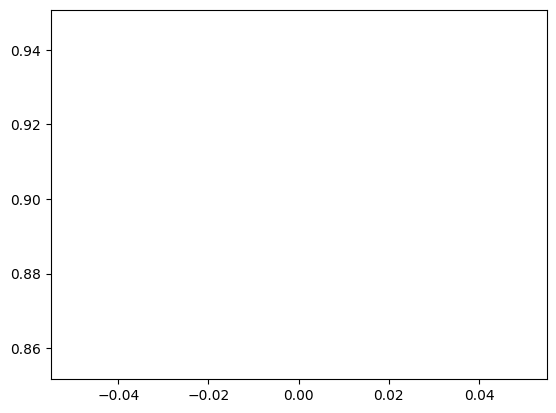

In [49]:
plt.plot(l_test[:,0])

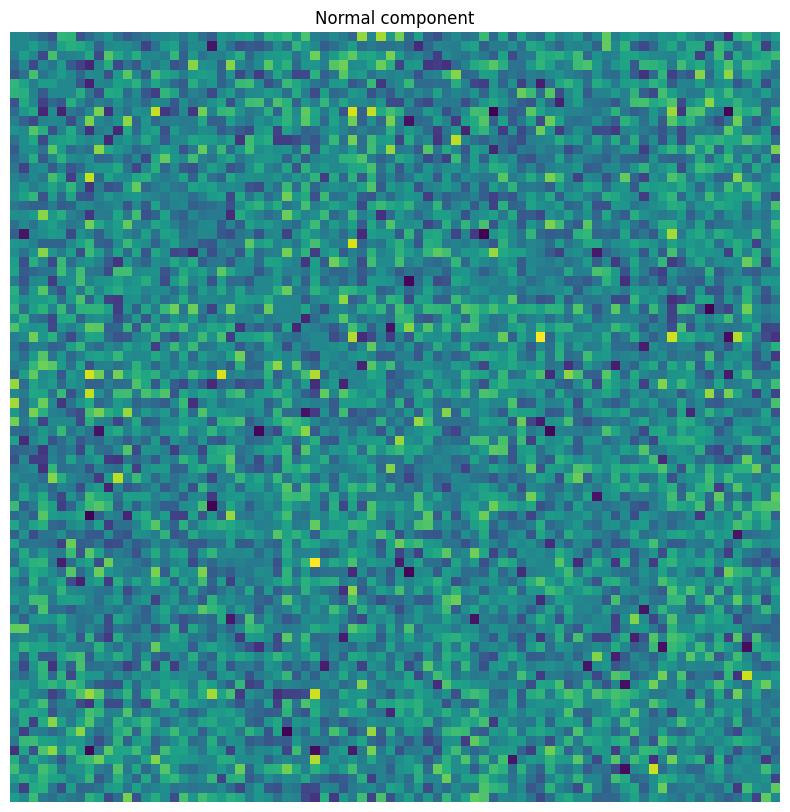

In [40]:
fig = plt.figure(figsize=(10,10))
n = 82
u_scaled = StandardScaler().fit_transform(u)
im = np.zeros((n,n))
iu = np.triu_indices(n,k=1)
il = np.tril_indices(n,k=-1)
im[iu[0],iu[1]] = u_scaled[:,2]
im = np.transpose(im)
im[iu[0],iu[1]] = u_scaled[:,2]
plt.imshow(im)
plt.axis("off")
plt.title(label="Normal component")
plt.show()

In [69]:
structural = np.loadtxt("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/structural.txt")

In [90]:
X = dfc[id_sessions_awake_sevoflurane,:,:,:].reshape(-1,82,82)

In [93]:
l = []
mask = (structural > 2)
for i in range(len(X)):
    accu = np.sum(mask * StandardScaler().fit_transform(X[i,:,:]))
    l.append(accu)

In [88]:
l = np.array(l)
l -= 82

24894

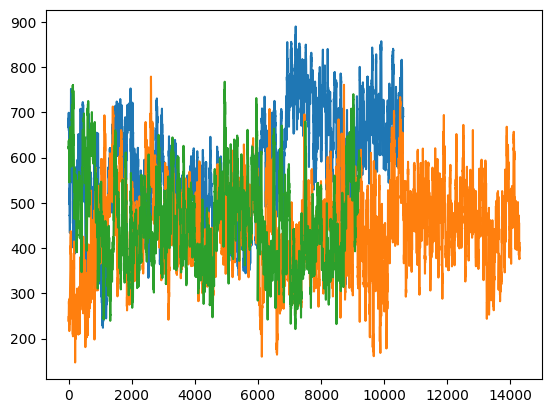

In [94]:
a = len(id_sessions_awake)
b = len(id_sessions_light_sevoflurane)
c = len(id_sessions_deep_sevoflurane)
plt.plot(l[461*a:461*(a+b)])
plt.plot(l[:a*461])
plt.plot(l[(a+b)*461:])

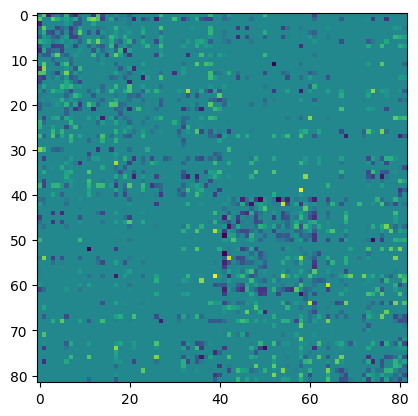

In [71]:
plt.imshow((structural > 2) * im)

In [144]:
transition_list = []
u_scaled = StandardScaler().fit_transform(u)
graph = np.zeros((82,82))
iu = np.triu_indices(n,k=1)
il = np.tril_indices(n,k=-1)
graph[iu[0],iu[1]] = u_scaled[:,i]
graph = np.transpose(graph)
graph[iu[0],iu[1]] = u_scaled[:,i]
for a in range(82):
    for b in range(82):
        if np.abs(graph[a,b]) > 2.5:
            transition_list.append((a,b))

In [141]:
transition_list

[(8, 15),
 (8, 36),
 (15, 8),
 (21, 50),
 (22, 36),
 (29, 74),
 (32, 56),
 (32, 77),
 (33, 67),
 (36, 8),
 (36, 22),
 (41, 43),
 (42, 57),
 (43, 41),
 (50, 21),
 (53, 77),
 (56, 32),
 (57, 42),
 (61, 67),
 (65, 69),
 (67, 33),
 (67, 61),
 (68, 78),
 (69, 65),
 (74, 29),
 (77, 32),
 (77, 53),
 (78, 68)]

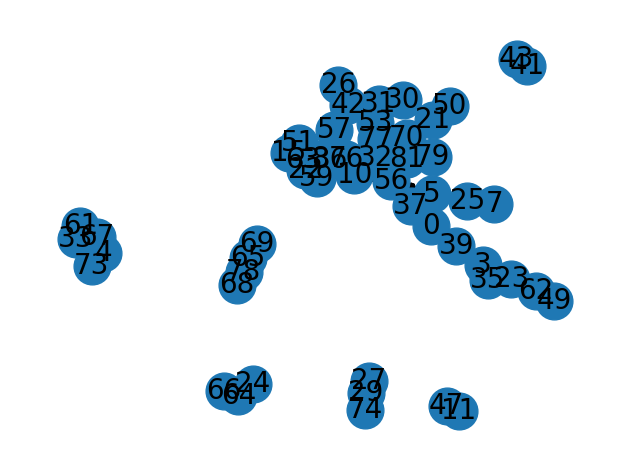

In [146]:
G = nx.DiGraph()

edges = transition_list

for edge in edges : 
    G.add_edge(edge[0], edge[1])

pos = nx.spring_layout(G, seed=7)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=transition_list, width=3, arrowstyle="->",arrowsize=10)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()